# Histopathologic Cancer Detection

## 1. Project overview

## 1.1. Problem definition and objective

The detection of cancer with appropriate accuracy and speed is amongst the most important challenges in modern medicine. In order to detect cancer pathologists have to analyze microscopic images of tissue. The analysis process is difficult, requires a lot of effort, and can be prone to errors. Machine learning models, in particular Convolutional Neural Networks, can be an essential tool in solving this issue. With a properly trained CNN we can automate cancer detection, decrease the error rate and drastically reduce the time needed for the analysis.

The overall objective of this project is to train a model in the detection of metastatic tissue in histopathologic scans of lymph node sections. To achieve this I'm going to:

*   Analyze the data and clean it up
*   Explore different architectures for the model and hyperparameters
*   Test different architectures nad find the optimal set up for the model
*   Analyze the results
*   Conclude how the whole process went and what could be optimized in the future.

## 1.2. Dataset source and structure

The data for this project comes from the PatchCamelyon (PCam) dataset, available through the "Histopathologic Cancer Detection" Kaggle competition. The PCam dataset consists of a collection of 96x96 pixel color images extracted from whole-slide images of lymph node sections.

The structure of the data set is as follows:

*   Train folder containing 220,025 labeled images

* Test folder containing approximately 57,458 unlabeled images

* A train_labels.csv file, which maps each image ID in the training set to a binary label: 1 for detected tumor in the tissue and 0 for lack of a detected tumor.

It's important to note that per the instruction on Kaggle: "A positive label indicates that the center 32px x 32px region of a patch contains at least one pixel of tumor tissue.", which means that instead of assessing 96px x 96px image, we have to focus on its smaller (32px x 32px) center. According to the Kaggle instruction this outer area have been provided to create padding for convolutional models.

## 1.3 General approach to the solution
Following the guidance on Kaggle website, and the fact that this project is the task for the CNN part of the Deep Learning course, I'm going to explore training a CNN and I'll attempt trying to define the architecture that's going to perform well on the task


## References

B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

# 2. Exploratory Data Analysis

The first critical set is to thoroughly analyze the data and see if there are any necessary clean-up procedures that have to be used before model training. I'm going to:


*   Load the data and perform the initial inspection (via ```head()```)
*   Analyze the distribution of two classes (how many items have positive vs. negative labels)
*   Visualize samples of images
*   Determine if we need to clean up the data



## 2.1 Loading data and initial analysis 

Based on the head data I can see the general structure of data in the train_labels.csv. The data consists of IDs representing images and binary labels. `info()` shows that we have the overall of 220025 observations with IDs being on type `object` and labels `int64`.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# path to data
train_path = 'histopathologic-cancer-detection/train/'
test_path = 'histopathologic-cancer-detection/test/'

try:
    labels_df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
    # basic info
    print("DataFrame Head:")
    display(labels_df.head())
    print("\nDataFrame Info:")
    labels_df.info()

except FileNotFoundError:
    print(f"Error: Could not find the file at '{LABELS_PATH}'")
    print("Please make sure the 'histopathologic-cancer-detection' folder is in the same directory as your notebook.")

DataFrame Head:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


## 2.2 Distribution of classes
To ensure that the data is good for model training, I'm checking how many observations do we have representing cancer (1) and no cancer (0) data. The analysis shows that the data is generally well-balanced with:
* 59.5% observations for 0 - no cancer
* 40.5% observations for 1 - cancer

Having this kind of well balanced data set means that I won't have to deploy any advanced strategies for data sampling to train a well performing model.

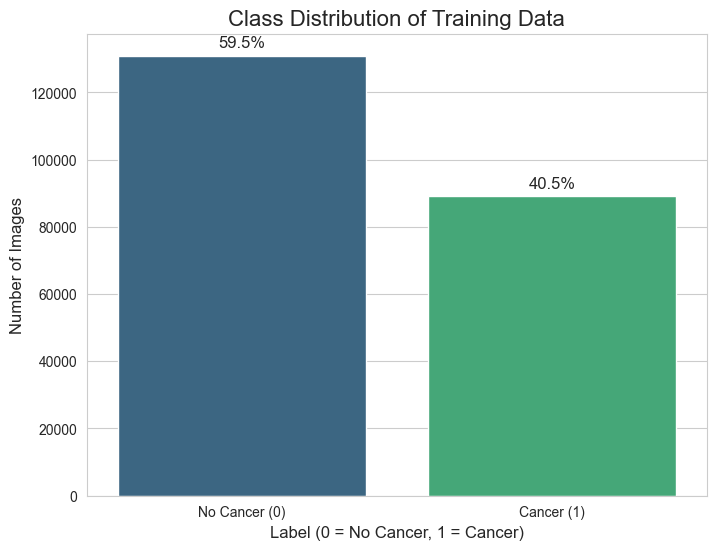

In [25]:
# Distribution of classes visualization
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='label', data=labels_df, palette='viridis', hue='label', legend=False)
plt.title('Class Distribution of Training Data', fontsize=16)
plt.xlabel('Label (0 = No Cancer, 1 = Cancer)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'])

# percentage annotation for clearer image
total = len(labels_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=12)

plt.show()

## 2.3 Visualization of image samples
Next in the EAD, I'm visualizing the actual images in the train test to understand how difficult is the problem and pick the appropriate method for building the method. Looking at the images I cannot detect any obvious traits that could help me see the difference between cancerous and non-cancerous tissue. The model will have to be very sophisticated to detect the patterns.

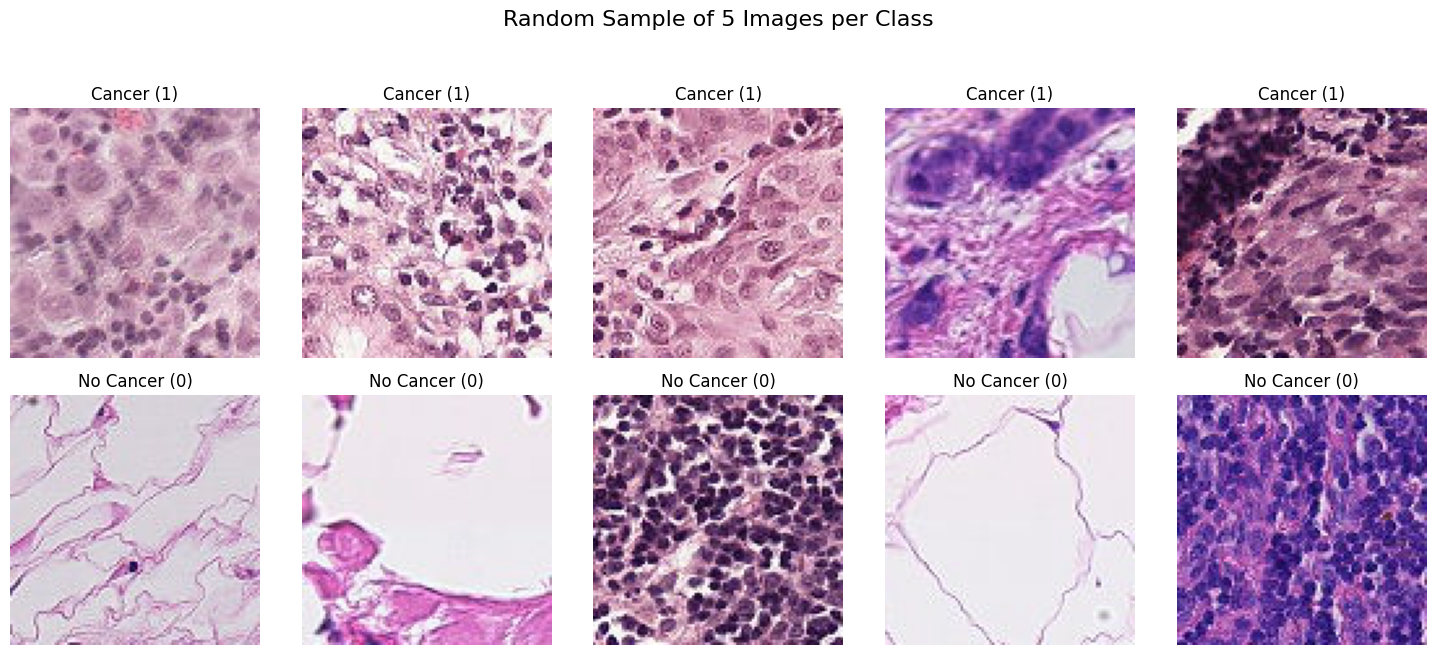

In [3]:
# I'm going to sample 5 cancerous and 5 non-cancerous scans to get a decent comparison
n_samples = 5

# Plots that I'm goign to use for image visualizations
fig, axes = plt.subplots(2, n_samples, figsize=(15, 7))
fig.suptitle(f'Random Sample of {n_samples} Images per Class', fontsize=16)

# Cancerous scans. Getting n_samples
cancer_ids = labels_df[labels_df['label'] == 1]['id'].sample(n_samples)
# Iterating through ids 
for i, img_id in enumerate(cancer_ids):
    # loading image of a given id
    img_path = os.path.join(train_path, img_id + '.tif')
    img = cv2.imread(img_path)
    
    ax = axes[0, i]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title("Cancer (1)")
    ax.axis('off')

# Non-cancerous scans. Getting n_samples
no_cancer_ids = labels_df[labels_df['label'] == 0]['id'].sample(n_samples)
for i, img_id in enumerate(no_cancer_ids):
    img_path = os.path.join(train_path, img_id + '.tif')
    img = cv2.imread(img_path)
    
    ax = axes[1, i]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title("No Cancer (0)")
    ax.axis('off')

# Layout for the plot
plt.tight_layout(pad=3.0)
plt.show()


## 2.4 Summary of EAD

Based on the analysis the data set doesn't need any additional clean-up. The dataset is well balanced and doesn't seem to have any missing observations. The only issue is that the model will have to learn very intrinsic patterns.

Moving forward my general plan is as follows: 
* Data Partitioning: I'll divide the train set into train and validation, so I have a set with labels to test the accuracy model
* Model Development: I'll start by training Convolutional Neural Network (CNN) and evaluating the performance
* Model tuning: I'll tune parameters of the model and try to improve the performance. 

# 3. Model Architecture

To detect which of the tissue scans are cancerous and which are non-cancerous we'll have to train a model able to classify images based on very detailed patterns. The best model architecture for this kind of situation will be the Convolutional Neural Network (CNN). CNN is able to learn hierarchy of features — from everything – edges and colors in the initial layers to complex textures and cell formations in deeper layers. Taking the complexity of the task, this is going to be invaluable. 

## Baseline Architecture and Hyperparameter Tuning

My approach will be to first train and evaluate a baseline CNN. This model will consist of one convolutional layer (Conv2D layer for feature extraction), a MaxPooling2D and flattening layer to reduce dimensionality, one dense layer to proces features and run a classifier, and output layer. 

The key part of the process will be to tune the hyperparameters and optimize the performance. I'm going to focus on the following covered in the MSAI course: 
* Learning Rate. I will experiment with values like 0.001 and 0.0001.
* Optimizer. I will start with the Adam optimizer and check other options.
* Dropout Rate. I will tune the dropout rate (e.g., 0.25, 0.5) to find the right amount of regularization and avoid overfitting

In [3]:
# Installing tensorflow for the model training

!python3 -m pip install tensorflow-macos tensorflow-metal


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 3.1 Data split

First, I'm splitting the data into test and train sets to calculate accuracy of the model. The initial attempt to load the data to numpy arrays was resulting in kernel restarts. After analysing the dpcumentation I decided to use cv2 to read images and then parse them with tf.py_function, reshape them and normalize them. This allowed me to load a large dataset without issues.


### References
The TensorFlow Authors. (2025). Better performance with the tf.data API. TensorFlow. https://www.tensorflow.org/guide/data_performance

The TensorFlow Authors. (2025). Load and preprocess images. TensorFlow. https://www.tensorflow.org/tutorials/load_data/images

Chollet, F., & others. (2025). Working with large datasets. Keras.io. https://keras.io/guides/working_with_large_datasets/

In [6]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split data into train and validation
train_df, valid_df = train_test_split(labels_df, test_size=0.1, random_state=42, stratify=labels_df['label'])

# Lists of filepaths
train_filepaths = 'histopathologic-cancer-detection/train/' + train_df['id'] + '.tif'
train_labels = train_df['label']
valid_filepaths = 'histopathologic-cancer-detection/train/' + valid_df['id'] + '.tif'
valid_labels = valid_df['label']

# Loading in batches and letting tf know that images are 96x96
IMG_SIZE = 96
BATCH_SIZE = 64

# OpenCV helper to read images
def read_and_decode_tif(filepath):
    img = cv2.imread(filepath.numpy().decode('utf-8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Helper to parse all the images
def parse_image(filepath, label):
    # Parsing with tf.py_function and the CV2 code
    image = tf.py_function(read_and_decode_tif, [filepath], Tout=tf.uint8)
    
    # Setting each tensor to 96x96 and 3 layrs 
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    
    # Normalization
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

# Final datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_filepaths, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_filepaths))
train_dataset = train_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_filepaths, valid_labels))
valid_dataset = valid_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

## 3.2 Training of the initial model

The initial training of the model comprises of the following layers:
* Input taking 96x96 pre-processed images
* Convolution layer with relu activation
* Dense layer with 64 neurons and relu activation
* Output layer with sigmoid activation

I'm also using maxpooling and flattening to focus the model on the most important patterns

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,524,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,525,057 (17.26 MB)

 Trainable params: 4,525,057 (17.26 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 237s 76ms/step - accuracy: 0.7652 - auc: 0.8200 - loss: 0.6896 - val_accuracy: 0.7404 - val_auc: 0.8839 - val_loss: 0.5469
Epoch 2/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 234s 76ms/step - accuracy: 0.8030 - auc: 0.8736 - loss: 0.4359 - val_accuracy: 0.8146 - val_auc: 0.8897 - val_loss: 0.4126
Epoch 3/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 235s 76ms/step - accuracy: 0.8138 - auc: 0.8843 - loss: 0.4179 - val_accuracy: 0.7656 - val_auc: 0.8927 - val_loss: 0.4943
Epoch 4/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 238s 77ms/step - accuracy: 0.7970 - auc: 0.8628 - loss: 0.4600 - val_accuracy: 0.7749 - val_auc: 0.8512 - val_loss: 0.5191
Epoch 5/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 376s 121ms/step - accuracy: 0.7806 - auc: 0.8466 - loss: 0.4954 - val_accuracy: 0.7799 - val_auc: 0.8429 - val_loss: 0.5229
Epoch 6/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 241s 78ms/step - accuracy: 0.7612 - auc: 0.8264 - loss: 0.5361 - val_accuracy: 0.7287 - val_auc: 0.8411 

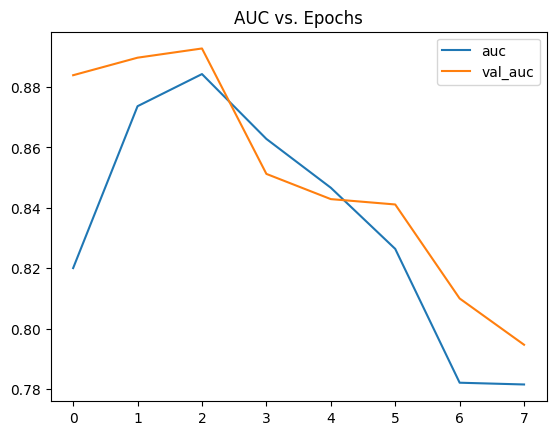

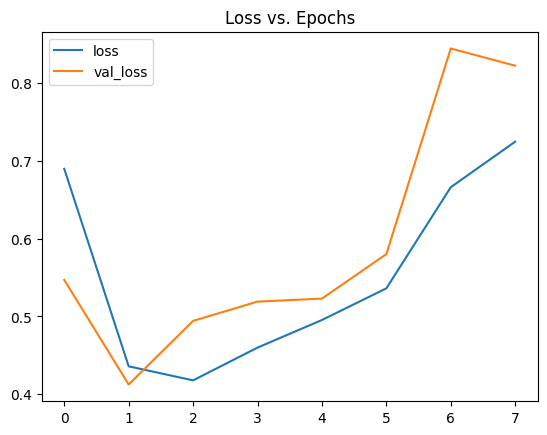

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt

# Model architecture
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Shows a table with model architecture
model.summary()

# Defines early stopping to stop learning when the model stopps improving
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

# Fit the model
print("\nStarting model training...")
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=1
)
print("\n Training complete.")

# Visualize training history with AUC and Loss plots
print("\nPlotting training history...")
history_df = pd.DataFrame(history.history)
history_df[['auc', 'val_auc']].plot(title="AUC vs. Epochs")
plt.show()
history_df[['loss', 'val_loss']].plot(title="Loss vs. Epochs")
plt.show()

## 3.2.1 Initial model – summary

The initial model training has not been successful. While the model stopped after 8/20 epochs (stopped by early_stopping) it never reached good performance. In the initial two epochs the model minimized the loss and AUC increased to 0.89 on validation set (peak performance), but after the second epoch the loss started to increase and the AUC started to rapidly drop. The model became quickly unstable and started to unlearn what it theoretically learned in the first 2 epochs. This is the sign of a completely wrong architecture. I assume that a single layer of convolution is just insufficient to support finding patterns in 96x96 image.

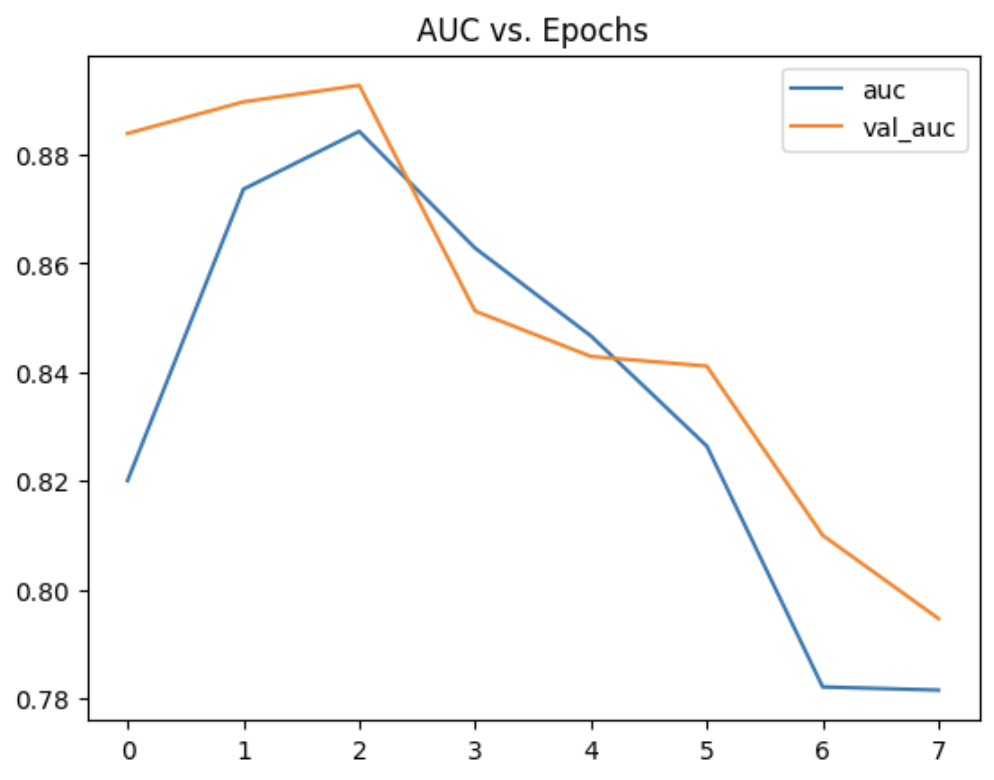
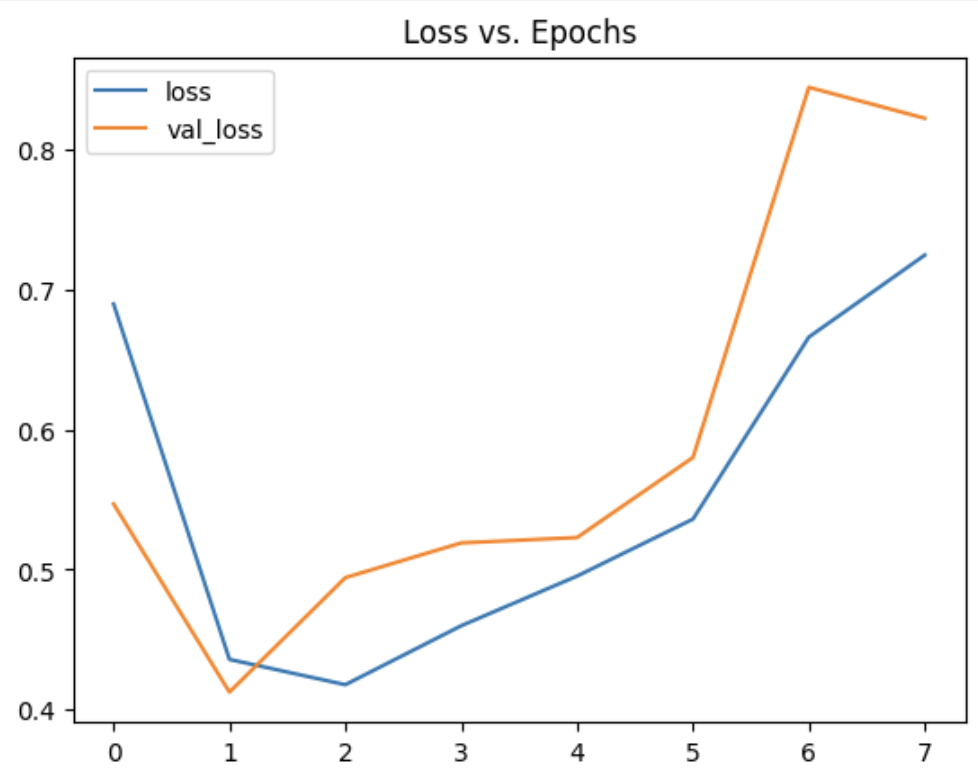

I'll define a new model with a more complex architecture.

# 3.3 Second version of the model – more complex architecture.

This time my model includes: 
- two Convolution layers with relu activation, MaxPooling and batch normalization for regularization
- dropout layer for a further regulization and focus only on the most important feature
- Dense layer of 128 neurons with relu activation as a classifier
- anther dropout layer 
- Output layer

I also lowered the learning rate to 0.0001 after an unsuccessful attempt at running the model with the previous learning rate (the loss exploded after one epoch)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,961 (15.20 MB)

 Trainable params: 3,984,769 (15.20 MB)

 Non-trainable params: 192 (768.00 B)


Starting model training...
Epoch 1/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 243s 78ms/step - accuracy: 0.6350 - auc: 0.6463 - loss: 135.8455 - val_accuracy: 0.8117 - val_auc: 0.8083 - val_loss: 11.1448
Epoch 2/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 235s 76ms/step - accuracy: 0.7480 - auc: 0.7432 - loss: 14.4399 - val_accuracy: 0.7870 - val_auc: 0.8003 - val_loss: 5.0694
Epoch 3/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 245s 79ms/step - accuracy: 0.7614 - auc: 0.7614 - loss: 9.0172 - val_accuracy: 0.8278 - val_auc: 0.8485 - val_loss: 3.1558
Epoch 4/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 247s 80ms/step - accuracy: 0.7675 - auc: 0.7764 - loss: 5.7471 - val_accuracy: 0.8283 - val_auc: 0.8694 - val_loss: 1.4053
Epoch 5/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 251s 81ms/step - accuracy: 0.7778 - auc: 0.8078 - loss: 2.1533 - val_accuracy: 0.7884 - val_auc: 0.8630 - val_loss: 0.4661

✅ Training complete.

Plotting training history...


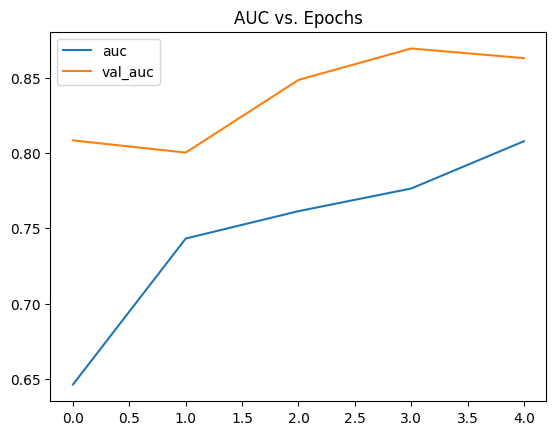

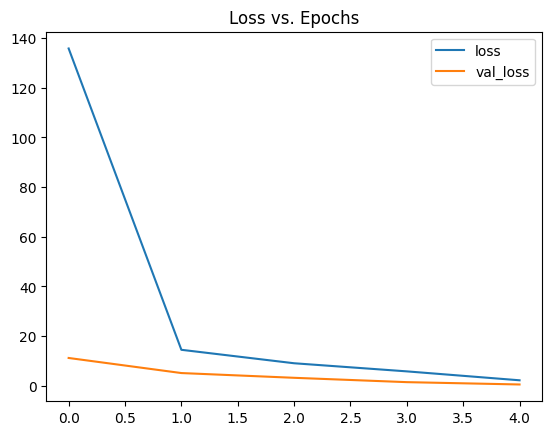

In [12]:
model_v2 = Sequential([
    Input(shape=(96, 96, 3)),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Dropout for regularization
    Dropout(0.25),

    # Classifier
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Model compile with a smaller learnign rate
model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model_v2.summary()

print("\nStarting model training...")
history = model_v2.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=1
)
print("\n Training complete.")

print("\nPlotting training history...")
history_df = pd.DataFrame(history.history)
history_df[['auc', 'val_auc']].plot(title="AUC vs. Epochs")
plt.show()
history_df[['loss', 'val_loss']].plot(title="Loss vs. Epochs")
plt.show()

## 3.3.1 Second model – summary

The second model performed much better. I had initial attempt without decreasing the learning rate that has not been successful, but after lowering it the model performed reasonably well. Clearly adding a little bit more depth has helped the model learn the patterns in histopathologic scans.

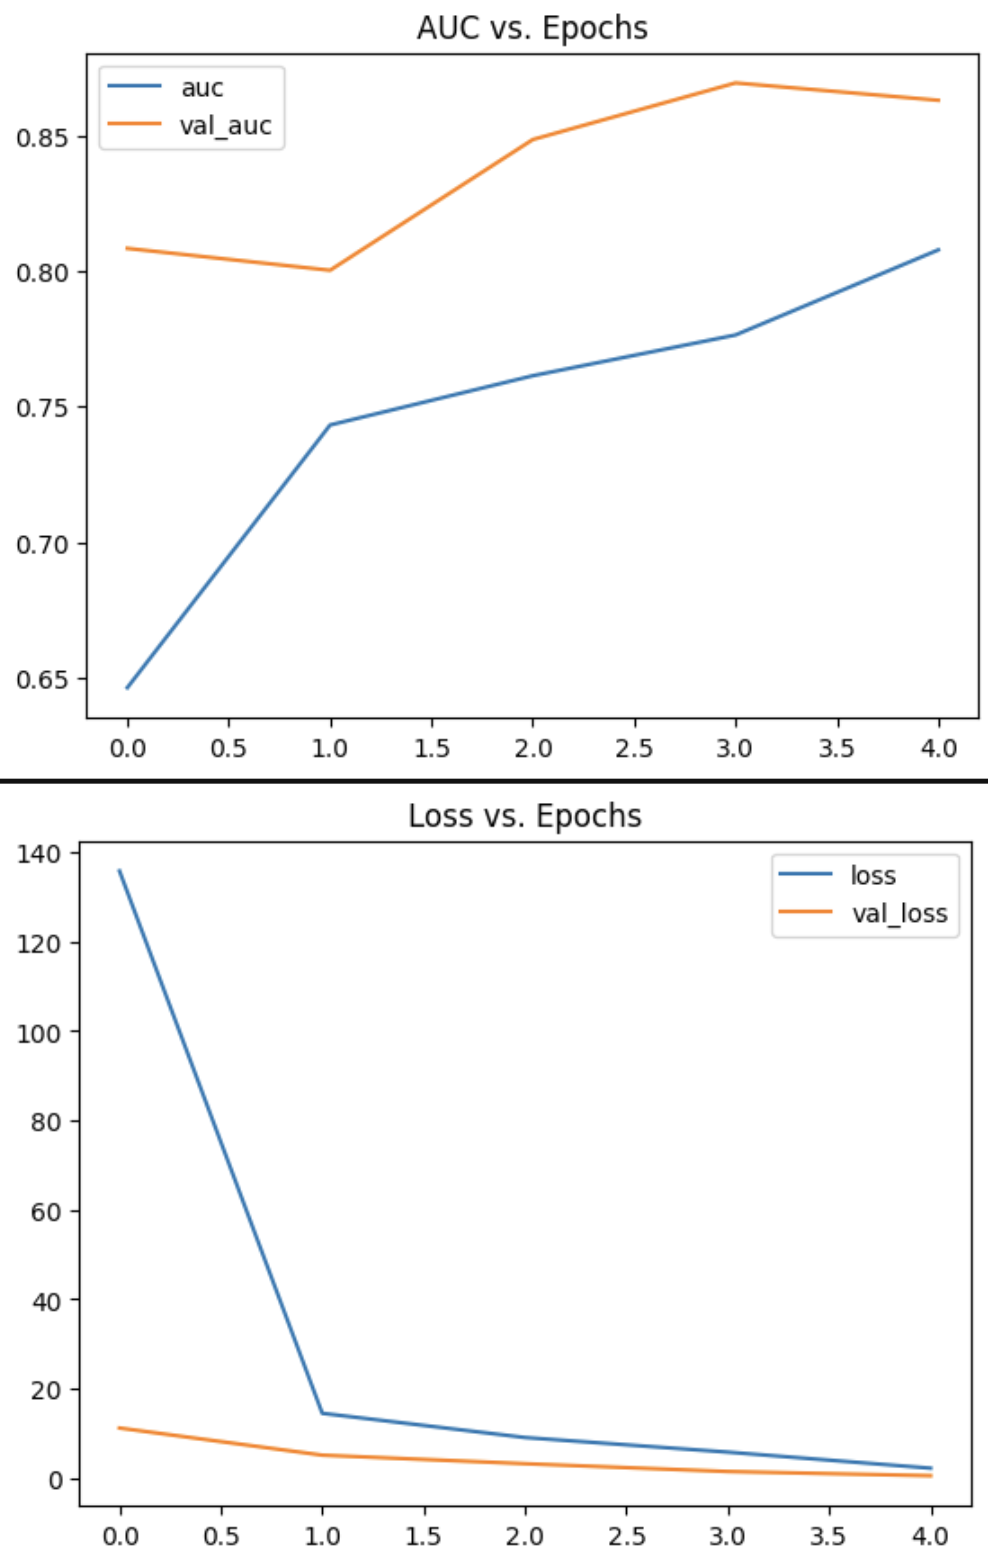

After this successful experiment I decided to try to create an even deeper architecture with 3 convolution layers. 

## 3.4 Third version of the model – deeper architecture.

Trying to optimize the performance of the model I tried an even deeper architecture


This time my model includes: 
- three Convolution layers with relu activation, MaxPooling and batch normalization for regularization (32, 64, 128 neurons)
- dropout layer for a further regulization and focus only on the most important feature
- Dense layer of 256 neurons with relu activation as a classifier
- anther dropout layer 
- Output layer

To err on the side of caution after prior attempts I also lowered the learning rate to 0.00001. I also tweaked dropout slightly to 0.3.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Model 3 with deeper architecture
model_v3 = Sequential([
    Input(shape=(96, 96, 3)),

    # First convolution
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Second convolution
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Third convolution
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Regularization
    Dropout(0.3), 

    # Classifier
    Flatten(),
    Dense(256, activation='relu'), 
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with the previous learning rate
model_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model_v3.summary()

# Training
print("\nStarting model training...")
history = model_v3.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=1
)
print("\n Training complete.")

print("\nPlotting training history...")
history_df = pd.DataFrame(history.history)
history_df[['auc', 'val_auc']].plot(title="AUC vs. Epochs")
plt.show()
history_df[['loss', 'val_loss']].plot(title="Loss vs. Epochs")
plt.show()

## 3.4.1 Third model – summary

Unfortunately this attempt has failed completely and I aborted training. After just one epoch the validation loss started to rapidly increase. This has been a valuable lesson – simply increasing model's depth does not always lead to better performance. A network this deep can become very difficult to train, creating an unstable loss that the optimizer cannot figure out. Even  an extremely small learning rate didn't help. 

Since going deeper didn't work out, my next experiment is to try creating a wider model.

## 3.5 Fourth model – wider architecture

Finally, after the failed attempt at creating a deeper architecture, I decided to get back to two convolution layers, but make them wider by creating more neurons (64 and 128) with the hope of creating a model more effectivelly capturing the complexity of cancer patterns on the scans.

The Fourth model consists of:
- 2 convolution layers (64 and 128 pixels) both with  MaxPooling and BatchNormalization and relu activation
- Dropout layer
- Dense layer with 256 neurons (classifier) with relu activation
- Another dropout layer

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,936,641 (60.79 MB)

 Trainable params: 15,936,257 (60.79 MB)

 Non-trainable params: 384 (1.50 KB)


Starting model training...
Epoch 1/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 416s 133ms/step - accuracy: 0.6595 - auc: 0.6654 - loss: 230.0220 - val_accuracy: 0.8132 - val_auc: 0.7906 - val_loss: 33.1812
Epoch 2/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 405s 131ms/step - accuracy: 0.7605 - auc: 0.7511 - loss: 48.1826 - val_accuracy: 0.5624 - val_auc: 0.6303 - val_loss: 52.9881
Epoch 3/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 403s 130ms/step - accuracy: 0.7641 - auc: 0.7557 - loss: 35.1537 - val_accuracy: 0.8118 - val_auc: 0.8232 - val_loss: 17.6371
Epoch 4/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 410s 132ms/step - accuracy: 0.7643 - auc: 0.7568 - loss: 31.5889 - val_accuracy: 0.8245 - val_auc: 0.8155 - val_loss: 13.9524
Epoch 5/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 408s 132ms/step - accuracy: 0.7691 - auc: 0.7635 - loss: 21.7529 - val_accuracy: 0.8163 - val_auc: 0.7999 - val_loss: 6.4604

✅ Training complete.

Plotting training history...


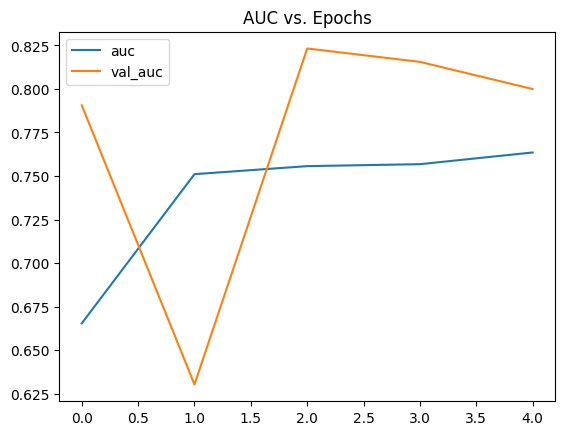

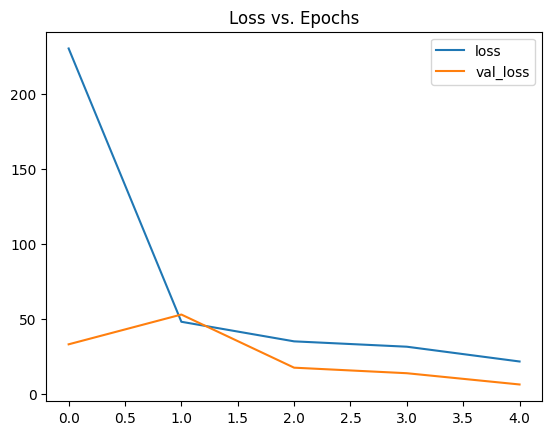

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Model v4 with a wider architecture
model_v4 = Sequential([
    Input(shape=(96, 96, 3)),

    # First convolution: Learn 64 features instead of 32
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Second convolution: Learn 128 features instead of 64
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Regularization
    Dropout(0.3),

    # Classifier with more neurons to learn more features
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_v4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model_v4.summary()

print("\nStarting model training...")
history = model_v4.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=1
)
print("\n Training complete.")

print("\nPlotting training history...")
history_df = pd.DataFrame(history.history)
history_df[['auc', 'val_auc']].plot(title="AUC vs. Epochs")
plt.show()
history_df[['loss', 'val_loss']].plot(title="Loss vs. Epochs")
plt.show()

#### 3.5.1 Fourth model – summmary

The fourth model didn't perform better than the second model. Too wide model became very problematic in training and we cna observe that valudation AUC went down after an epoch, than up again and down again. The model failed at consistently learning the patterns in data.

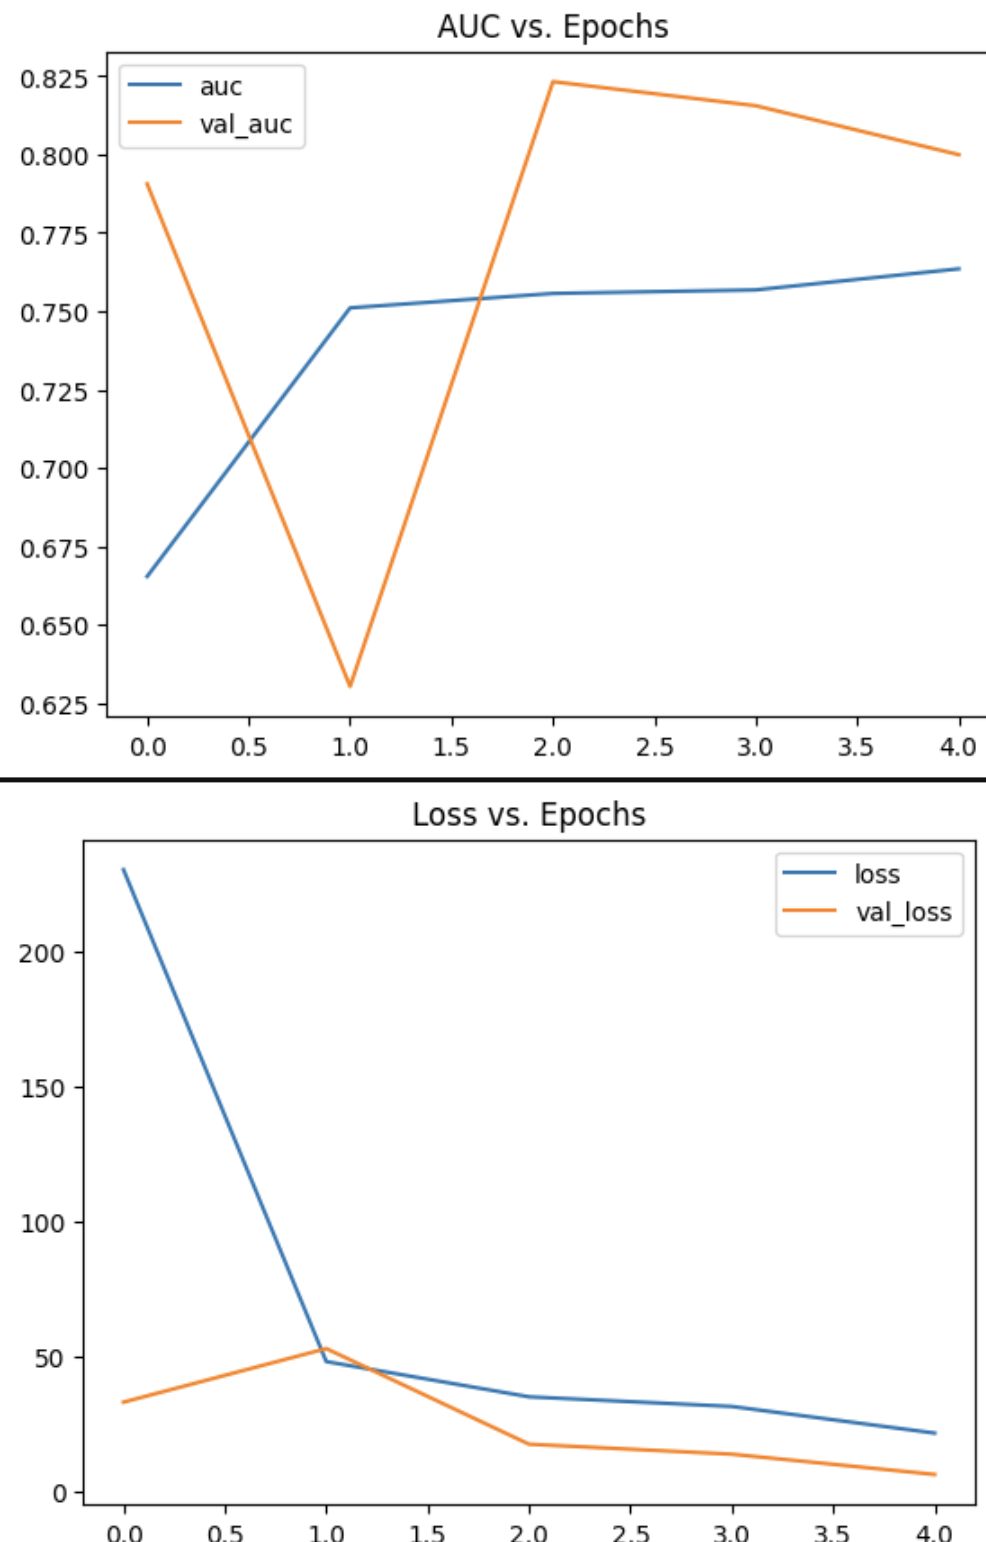

## 3.6 Best model – optimization
My second model with two convolution layers (32 and 64) performed the best. In the final optimization attempt I'm going to rerun it with RMSprop instead of Adam optimizer and compare results.

Compiling the model with RMSprop optimizer...


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,961 (15.20 MB)

 Trainable params: 3,984,769 (15.20 MB)

 Non-trainable params: 192 (768.00 B)


Starting final model training...
Epoch 1/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 235s 75ms/step - accuracy: 0.6007 - auc: 0.6174 - loss: 196.1270 - val_accuracy: 0.7644 - val_auc: 0.7648 - val_loss: 28.5335
Epoch 2/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 237s 77ms/step - accuracy: 0.7437 - auc: 0.7382 - loss: 25.1271 - val_accuracy: 0.8215 - val_auc: 0.8307 - val_loss: 8.7882
Epoch 3/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 236s 76ms/step - accuracy: 0.7657 - auc: 0.7616 - loss: 14.2251 - val_accuracy: 0.8108 - val_auc: 0.7918 - val_loss: 11.3339
Epoch 4/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 238s 77ms/step - accuracy: 0.7723 - auc: 0.7701 - loss: 12.1988 - val_accuracy: 0.8475 - val_auc: 0.8531 - val_loss: 4.1641
Epoch 5/20
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 239s 77ms/step - accuracy: 0.7784 - auc: 0.7794 - loss: 9.1329 - val_accuracy: 0.8426 - val_auc: 0.8519 - val_loss: 4.4174

 Final training complete.

Plotting final training history...


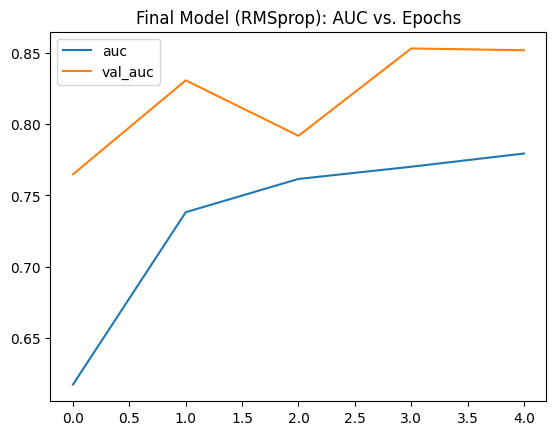

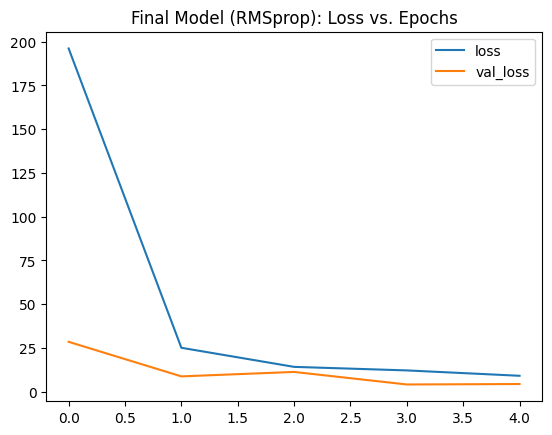

In [17]:
# Final model with RMSprop optimizer
model_final = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Change from ADAM to RMSprop
print("Compiling the model with RMSprop optimizer...")
model_final.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), # Changed from Adam
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model_final.summary()

print("\nStarting final model training...")
history_final = model_final.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
    verbose=1
)
print("\n Final training complete.")

print("\nPlotting final training history...")
history_df_final = pd.DataFrame(history_final.history)
history_df_final[['auc', 'val_auc']].plot(title="Final Model (RMSprop): AUC vs. Epochs")
plt.show()
history_df_final[['loss', 'val_loss']].plot(title="Final Model (RMSprop): Loss vs. Epochs")
plt.show()

### 3.6.1 Best model – optimization – summary

The change of optimizer to RMSprop turned out to be unsuccessful. The validation loss started to increase after the 3rd epoch despire continued improvement in training. Adam optimizer uses momentum to keep moving in a generally good direction. It essentially smoothes out small bumps on the loss charts. RMSprop is more reactive to the immediate "terrain" of the loss landscape. In this case, it seems to have found a good spot in epoch 2 but then "jumped" to a worse spot in epoch 3, again performed well in epoch 4 and fail in epoch 5. This kind of erratic training made it impossible for RMSprop to beat Adam in building a stable model.

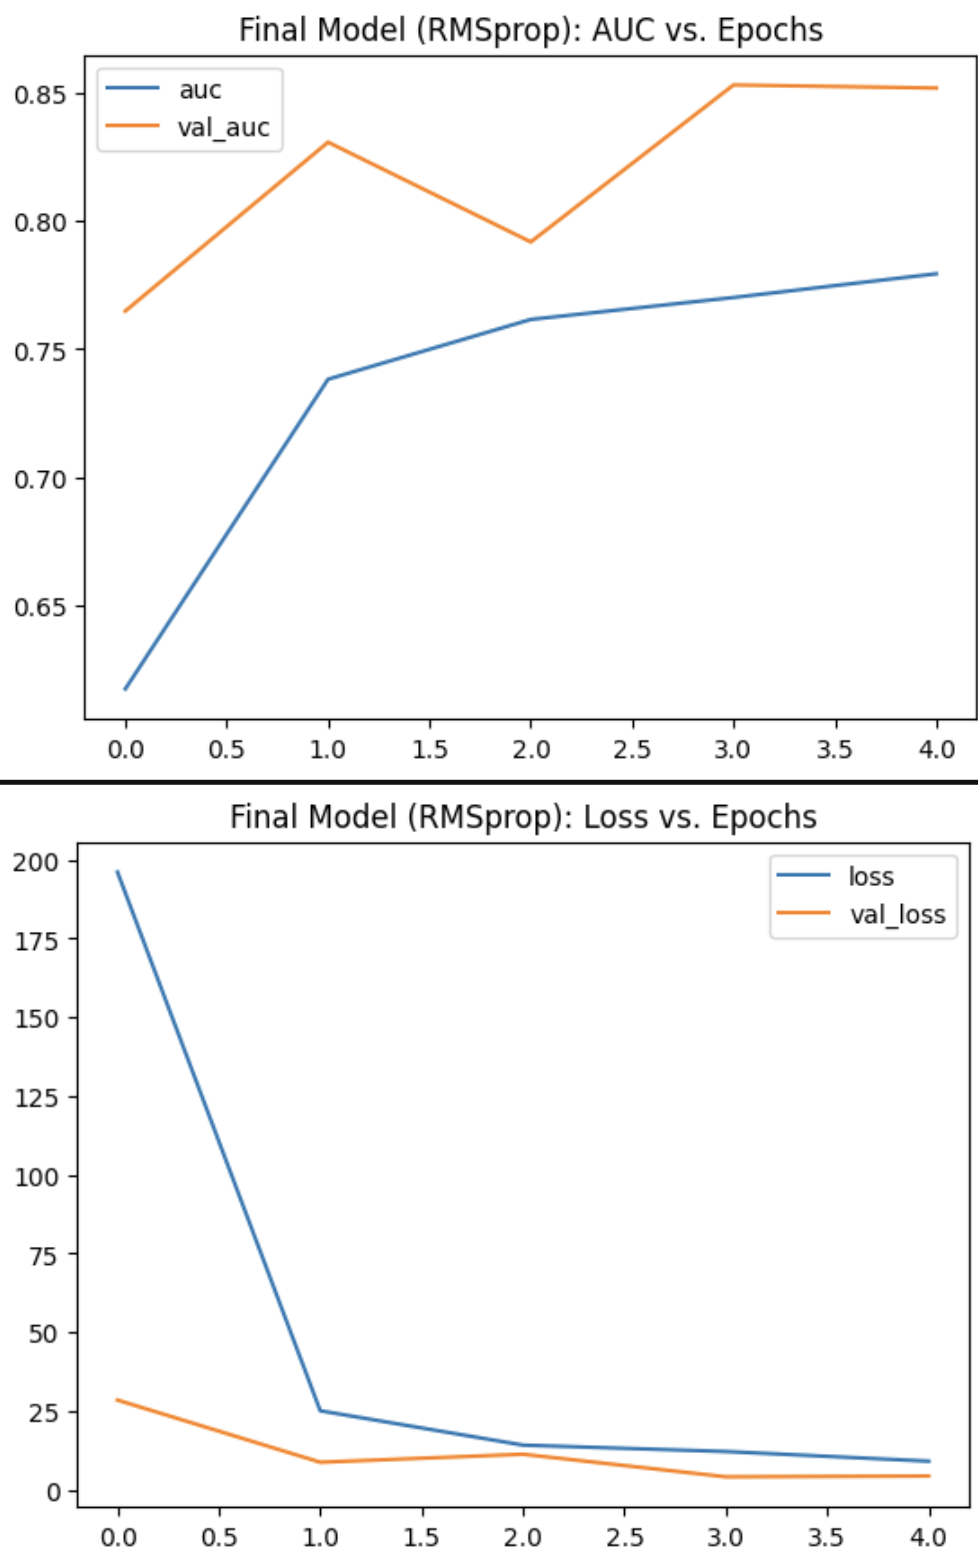

# 4. Results and Analysis

This series of experiments turns out to be a fantastic lesson (with many failures!) of building CNNs. The following table shows the experiments:

| Experiment | Architecture | Key Hyperparameters | Peak `val_auc` | Peak Epoch | Analysis & Findings |
| :--- | :--- | :--- | :---: | :---: | :--- |
| **Model v1** | 1 Conv Block (32) <br> 1 Dense Layer (64) | Adam (lr=0.001) | ~0.89 | 2 | **Unstable.** Learned very fast but became highly unstable and overfit almost immediately. |
| **Model v2** | 2 Conv Blocks (32, 64) <br> `BatchNormalization` <br> `Dropout` (0.25, 0.5) | Adam (lr=0.0001) | **~0.87** | 4 | **Stable & Successful.** The deeper, regularized architecture with a lower learning rate trained in a stable, healthy manner. The best model. |
| **Model v3** | 3 Conv Blocks (32, 64, 128) <br> `BatchNormalization`, `Dropout` | Adam (lr=0.00001) | ~0.84 | 2 | **Failed (Too Deep).** The model was too deep to train effectively. Training was highly unstable and performance was poor. |
| **Model v4** | 2 Conv Blocks (64, 128) <br> `BatchNormalization`, `Dropout` | Adam (lr=0.0001) | ~0.82 | 3 | **Failed (Too Wide).** A "wider" model also proved to be unstable, with erratic validation loss and lower performance than `model_v2`. |
| **Final (v2 Tuned)**| 2 Conv Blocks (32, 64) <br> `BatchNormalization`, `Dropout` | **RMSprop** (lr=0.0001) | ~0.85 | 4 | **Sub-optimal.** While it eventually found a good solution, the `RMSprop` optimizer was far more erratic than `Adam` and produced a lower peak AUC. |

The Model v2 with 2 CNNs and Adam optimizer has been proben to be the best. It reached a decent AUC on validation set (~0.87) and it was very stable in training. The failures of other models taught me the following lessons:
* Troubleshooting instability (v1 -> v2): The initial baseline model (v1) was too simple. Its single convolutional layer resulted in a massive, 4.5 million-parameter dense layer that was impossible to train in a stable way. The model's validation loss quickly diverged and overfit. The key improvement was adding a second convolutional layer. This approach turned out to be the key to success.

* Hyperparameter Tuning (Learning Rate): The model_v2 architecture was stable, but finding the correct learning rate was critical. The initial rate of 0.001 (from v1) caused the training to collapse. Reducing the learning rate to 0.0001 was the single most important step to build a successful model.

* Architectural Comparisons (v3, v4): The experiments with a "deeper" (v3) and "wider" (v4) model both failed to outperform model_v2. This demonstrates that "more complex" is not always "better." Both architectures were too complex for the given data and optimizer, resulting in unstable training and lower performance. 

* Optimizer Tuning: The final experiment confirmed that Adam was a better choice of optimizer for this architecture than RMSprop. While RMSprop eventually found a decent solution (peaking at 0.85 val_auc), its training was far more erratic, with wild swings in validation loss. The Adam optimizer provided a much smoother, more stable, and more reliable path to a better result.

# 5. Conclusions

I'll be honest. This has been a wild ride. Between different versions of the model I felt certain that I learned something critical that will scale and continue to improve the performance: 
* Turns out that it just wasn't true. Going too deep with the architecture of the model didn't work beyond 2 layers of convolutions
* Adding neurons (wider architecture) didn't work after the initial approach.
* Changing the learnign rate worked great once, but didn't help with more complex architectures.

All in all I take all of the lessons above as the sign that the key is to find a balance in the architecture and hyperparameters of the model.

If I had more time in this project I'd try some more advanced techniques:
* Increase of data set by applying augmentation / creating synthetic data. Flipping, and rotating images to increase the data set could help the model learn the patterns.
* Cropping images. I'm not sure if this would help, but since the key info was in the middle, I wonder if creating a smaller images (e.g. 64x64) with smaller padding would help convolution layer focus more on the key information.

This was fun!

# 6. Saving file for competition

In [18]:
test_path = 'histopathologic-cancer-detection/test/'

test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({'id': [f.replace('.tif', '') for f in test_filenames]})

test_filepaths = test_path + test_df['id'] + '.tif'
test_dataset = tf.data.Dataset.from_tensor_slices((test_filepaths, [0]*len(test_filepaths)))
test_dataset = test_dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
print("Making predictions on the test set...")

predictions = model_v2.predict(test_dataset, verbose=1)

print(f"Shape of predictions array: {predictions.shape}")

Making predictions on the test set...
898/898 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step
Shape of predictions array: (57458, 1)


In [20]:
submission_labels = predictions.flatten()

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'label': submission_labels
})

print("\nFirst 5 rows of the submission file:")
display(submission_df.head())

submission_df.to_csv('submission.csv', index=False)

print("\n Submission file 'submission.csv' created successfully!")


First 5 rows of the submission file:


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1.000000e+00
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,2.713150e-12
2,19709bec800f372d0b1d085da6933dd3ef108846,1.000000e+00
3,7a34fc34523063f13f0617f7518a0330f6187bd3,1.680323e-12
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.000000e+00



 Submission file 'submission.csv' created successfully!
